###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.

# Reaction-diffusion model

This IPython Notebook presents the context and set-up for the coding assignment of Module 4: _Spreading out: Diffusion problems_, of the course [**"Practical Numerical Methods with Python"**](https://github.com/numerical-mooc/numerical-mooc) (a.k.a., numericalmooc).

So far in this module, we've studied diffusion in 1D and 2D. Now it's time to add in some more interesting physics.  You'll study a model represented by *reaction-diffusion* equations.  What are they?  The name says it all—it's a system that has the physics of diffusion but also has some kind of reaction that adds different behaviors to the solution.

We're going to look at the _Gray-Scott model_, which simulates the interaction of two generic chemical species reacting and ... you guessed it ... diffusing! Some amazing patterns can emerge with simple reaction models, eerily reminiscent of patterns formed in nature. It's fascinating! Check out this simulation by Karl Sims posted on You Tube ... it looks like a growing coral reef, doesn't it?

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('8dTmUr5qKvI')

## Gray-Scott model

The Gray-Scott model represents the reaction and diffusion of two generic chemical species, $U$ and $V$, whose concentration at a point in space is represented by variables $u$ and $v$. The model follows some simple rules.  

*  Each chemical _diffuses_ through space at its own rate.
*  Species $U$ is added at a constant feed rate into the system.
*  Two units of species V can 'turn' a unit of species U into V: $\; 2V+U\rightarrow 3V$
*  There's a constant kill rate removing species $V$.

This model results in the following system of partial differential equations for the concentrations $u(x,y,t)$ and $v(x,y,t)$ of both chemical species:

\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla ^2 u - uv^2 + F(1-u)\\
\frac{\partial v}{\partial t} &= D_v \nabla ^2 v + uv^2 - (F + k)v
\end{align}

You should see some familiar terms, and some unfamiliar ones.  On the left-hand side of each equation, we have the time rate of change of the concentrations. The first term on the right of each equation correspond to the spatial diffusion of each concentration, with $D_u$ and $D_v$ the respective rates of diffusion.

In case you forgot, the operator $\nabla ^2$ is the Laplacian:

$$
\nabla ^2 u = \frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}
$$

The second term on the right-hand side of each equation corresponds to the reaction. You see that this term decreases $u$ while it increases $v$ in the same amount: $uv^2$.  The reaction requires one unit of $U$ and two units of $V$,  resulting in a reaction rate proportional to the concentration $u$ and to the square of the concentration $v$. This result derives from the _law of mass action_, which we can explain in terms of probability: the odds of finding one molecule of species $U$ at a point in space is proportional to the concentration $u$, while the odds of finding two molecules of $V$ is proportional to the concentration squared, $v^2$. We assume here a reaction rate constant equal to $1$, which just means that the model is non-dimensionalized in some way.

The final terms in the two equations are the "feed" and "kill" rates, respectively: $F(1-u)$ replenishes the species $U$ (which would otherwise run out, as it is being turned into $V$ by the reaction); $-(F+k)v$ is diminishing the species $V$ (otherwise the concentration $v$ would simply increase without bound). 

The values of $F$ and $k$ are chosen parameters and part of the fun of this assignment is to change these values, together with the diffusion constants, and see what happens. 

## Your assignment

The system is represented by two arrays, `U` and `V`, holding the discrete values of the concentrations $u$ and $v$, respectively.  We start by setting `U = 1` everywhere and `V = 0` everywhere, then introduce areas of difference, as initial conditions.  We then add a little noise to the whole system to help the $u$ and $v$ reactions along.  

Below is the code segment we used to generate the initial conditions for `U` and `V`.  

**NOTE**: *DO NOT USE THIS CODE IN YOUR ASSIGNMENT*.
We are showing it here to help you understand how the system is constructed.  However, you _must use the data we've supplied below_ as your starting condition or your answers will not match those that the grading system expects.

```[Python]
num_blocks = 30
randx = numpy.random.randint(1, nx-1, num_blocks)
randy = numpy.random.randint(1, nx-1, num_blocks)
U = numpy.ones((n,n))
V = numpy.zeros((n,n))

r = 10
U[:,:] = 1.0

for i, j in zip(randx, randy):
    U[i-r:i+r,j-r:j+r] = 0.50
    V[i-r:i+r,j-r:j+r] = 0.25

U += 0.05*numpy.random.random((n,n))
V += 0.05*numpy.random.random((n,n))
```

*  Discretize the reaction-diffusion equations using forward-time/central-space and assume that $\Delta x = \Delta y = \delta$.

*  For your timestep, set 
$$\Delta t = \frac{9}{40}\frac{\delta^2}{\max(D_u, D_v)}$$

*  Use zero Neumann boundary conditions on all sides of the domain.

You should use the initial conditions and constants listed in the cell below.  They correspond to the following domain:

*  Grid of points with dimension `192x192` points
*  Domain is $5{\rm m} \times 5{\rm m}$
*  Final time is $8000{\rm s}$.

In [1]:
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline

In order to ensure that you start from the same initial conditions as we do, please download the file [uvinitial.npz](https://github.com/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/data/uvinitial.npz?raw=true)

This is a NumPy save-file that contains two NumPy arrays, holding the initial values for `U` and `V`, respectively.  Once you have downloaded the file into your working directory, you can load the data using the following code snippet.  

In [ ]:
uvinitial = numpy.load('./data/uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

In [ ]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);


## Sample Solution

Below is an animated gif showing the results of this solution for a different set of randomized initial block positions.  Each frame of the animation represents 100 timesteps.  

Just to get your juices flowing!

<img src="./figures/celldivision.gif">

# Solution

The Gray-Scott model could be approached with a similar way to the heat-diffusion examined in the previous notebooks. 
If we put together the conserved variables and the flux vector into our PDE, we get the following set of equations:

\begin{equation}
\frac{\partial}{\partial t}
\left[ \begin{array}{c}
\ u \\
\ v \\ 
\end{array} \right]
- \nabla^2
\left[ \begin{array}{c}
\ u \\
\ v\\ \end{array}
\right]
=\left[ \begin{array}{c}
\ -uv^2 + F(1-u) \\
\ uv^2 - (F+k)v \\
\end{array} \right]
\end{equation}


The system though will be solved with a forward time/central space scheme and with a Neumann boundary type of zero flux for all sides.

\begin{eqnarray}
\frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} & \nonumber \\
= D_u &\left( \frac{u^{n}_{i+1, j} 
- 2u^{n}_{i,j} + u^{n}_{i-1,j}}{\Delta x^2} + \frac{u^{n}_{i, j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{\Delta y^2}\right)
\end{eqnarray}

Rearranging the known terms with the unknown ones we get:

\begin{eqnarray}
{u^{n+1}_{i,j}} = {\Delta t}{D_u} &\left( \frac{u^{n}_{i+1, j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{\Delta x^2} + \frac{u^{n}_{i, j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{\Delta y^2}\right)
+ u^n_{i,j}
\end{eqnarray}

And since the mesh spacing is the same in both directions, $\Delta x=\Delta y = \delta$ and since the stability parameter $\sigma$ in this case is:

$\sigma = \frac{\delta^2}{D_u \Delta t}$:

\begin{eqnarray}
{u^{n+1}_{i,j}} = \sigma' &\left( u^{n}_{i+1, j} + u^{n}_{i-1,j} + \left(\sigma - 4 \right) u^n_{i,j} + u^{n}_{i, j+1} + u^{n}_{i,j-1}\right) 
\end{eqnarray}

Following the same procedure as with the heat-diffusion equation we can construct the 2D matrix A only that now the main diagonal is $\sigma-4$, the unity diagonals are 1 instead of -1 and we have to take into consideration that all boundaries are of Neumann type and since we are on the r.h.s of the quations (known terms) we add instead of subtrack. Let give an example similar to the heat-diffusion layout



E.g. Neu-Neu-Neu-Neu
        <-             nx-2               -> <- nx-2 ->     
    A1: sigma - 2, 1, 0, ...,              0|1 0 ...0  
        1        ,sigma - 4, 1, ...        1|0  1
        0        , ...          1, sigma - 2|        1
    
    A2: <- nx-2 -> <-                nx-2             -> <- nx-2 ->
        1 0 ... 0|sigma - 3, -1,        0, ...,   0  | 1, 0, ..., 0
        0 1 ... 0|1         sigma -4,   1, ...,   0  | 0, 1, ..., 0
            ...  |            ...             ,   1  |       ...
                1|                       1, sigma -3|             1
                
    A3: same as A1 but the I matrix in front of the 'sigma' diagonal one

The terms that are missing from the equations above that control the population update need to be added in each timestep before computing the unknown. It makes sense to have them computed on the current or previous timestep as an explicit term.

\begin{eqnarray}
{u^{n+1}_{i,j}} = \sigma' &\left( u^{n}_{i+1, j} + u^{n}_{i-1,j} + \left(1/\sigma' - 4 \right) u^n_{i,j} + u^{n}_{i, j+1} + u^{n}_{i,j-1}\right) + \left(-u^n_{i,j}(v^2)^n_{i,j} + F(1-u^n_{i,j})\right)*\Delta t
\end{eqnarray}

\begin{eqnarray}
{v^{n+1}_{i,j}} = \sigma' &\left( v^{n}_{i+1, j} + v^{n}_{i-1,j} + \left(1/\sigma' - 4 \right) v^n_{i,j} + v^{n}_{i, j+1} + v^{n}_{i,j-1}\right) + \left(u^n_{i,j}(v^2)^n_{i,j} - (F + k)v^n_{i,j}\right)*\Delta t
\end{eqnarray}

In [2]:
from scipy import sparse
from scipy.linalg import solve

Now we need to add the two additional terms that control the polulation in the Gray-Scott model that is

$ -u^n_{i,j}v^n_{i,j}v^n_{i,j} + F(1-u^n_{i,j})$

and something similar for the v concentration.

In [28]:
def ftcs_2D(U, V, nt, sigma, nx, ny, dt):
    """ Advances diffusion equation in time with backward Euler
   
    Parameters:
    ----------
    U: 2D array of float
        initial concentration
    A: 2D array of float
        Matrix with discretized diffusion equation
    nt: int
        number of time steps
    sigma: float
        alpha*dt/dx^2
    U_bc : float 
        Dirichlet BC temperature
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    dt   : float
        Time step size
        
    U[1:-1,1:-1]= Un[1:-1,1:-1]+ Du*(dt/dh*2(Un[2:,1:-1]-2*Un[1:-1,1:-1]+Un[:-2,1:-1]) +\   
    dt/dh*2(Un[1:-1,2:]-2*Un[1:-1,1:-1]+Un[1:-1,:-2])) -\       
    dt*Un[1:-1,1:-1](Vn[1:-1,1:-1])*2 +\ dt*F*(1-Un[1:-1,1:-1]) 
       
    Returns:
    -------
    U: 2D array of floats
        concentration after nt time steps
    """
    U_frame = numpy.empty((int(nt/100.)+1,U.shape[0],U.shape[1]))
    V_frame = numpy.empty((int(nt/100.)+1,U.shape[0],U.shape[1]))
   
    for t in range(nt):
        Un = U.copy()
        Vn = V.copy()
        
        # interior 
        U[1:-1,1:-1] = 1/sigma[0]*(Un[2:,1:-1] + Un[:-2,1:-1] + (sigma[0]-4)*Un[1:-1,1:-1] + \
                                Un[1:-1,2:] + Un[1:-1,:-2]) - dt*(Un[1:-1,1:-1]\
                                *Vn[1:-1,1:-1]**2 - F*(1 - Un[1:-1,1:-1]))
        
        V[1:-1,1:-1] = 1/sigma[1]*(Vn[2:,1:-1] + Vn[:-2,1:-1] + (sigma[1]-4)*Vn[1:-1,1:-1] + \
                                Vn[1:-1,2:] + Vn[1:-1,:-2]) + dt*(Un[1:-1,1:-1]\
                                *Vn[1:-1,1:-1]**2 - (F +k)* Vn[1:-1,1:-1])
        
        
        #Enforce Neummann BCs 
        U[0,:] = U[1,:]
        U[:,0] = U[:,1]
        U[-1,:] = U[-2,:]
        U[:,-1] = U[:,-2]
        
        V[0,:] = V[1,:]
        V[:,0] = V[:,1]
        V[-1,:] = V[-2,:]
        V[:,-1] = V[:,-2]
        
        
        print ("timestep ",t," u",U[100,::40])
        if t%100==0:
            U_frame[t/100,:,:]=U.copy()
            V_frame[t/100,:,:]=V.copy()
        
            
    return U_frame, V_frame

### Problem setup

### Initial condition data files

In [29]:
uvinitial = numpy.load('./data/uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

In [30]:
n = 192
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 
dh = 5./(n-1)
T = 8000
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

In [31]:
sigma = [dh**2/(dt*Du),dh**2/(dt*Dv)]

In [32]:
u, v = ftcs_2D(U, V, nt, sigma, n, n, dt)

timestep  0  u [ 1.01772594  1.01583579  1.02112811  1.0262791   1.02322707]
timestep  1  u [ 1.02283813  1.02681327  1.01986047  1.02473494  1.01523405]
timestep  2  u [ 1.01954183  1.01179448  1.01869717  1.022297    1.01596946]
timestep  3  u [ 1.02021283  1.00842545  1.018977    1.02361636  1.01401321]
timestep  4  u [ 1.01796354  0.99401641  1.01741301  1.0204705   1.01373867]
timestep  5  u [ 1.01785244  0.98795345  1.01699727  1.02141304  1.01303388]
timestep  6  u [ 1.01631278  0.97634414  1.01561656  1.01887752  1.01259081]
timestep  7  u [ 1.01596239  0.96981165  1.01469626  1.01928438  1.01222742]
timestep  8  u [ 1.01486922  0.96022128  1.0132816   1.01735621  1.01177827]
timestep  9  u [ 1.01444983  0.95365943  1.01200269  1.0174051   1.01150711]
timestep  10  u [ 1.01363124  0.94530323  1.01046024  1.01593235  1.01108236]
timestep  11  u [ 1.01320383  0.93874529  1.0089296   1.01577459  1.01081978]
timestep  12  u [ 1.01255677  0.93106862  1.00725019  1.01462751  1.010412

/Users/cm1y12/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cm1y12/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:60: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0

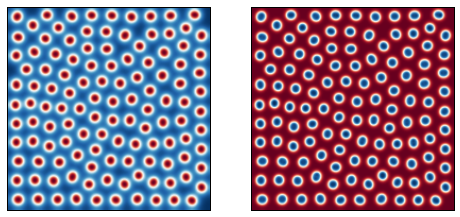

In [33]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(u[-1,:,:], cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(v[-1,:,:], cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

## Exploring extra patterns

Once you have completed the assignment, you might want to explore a few more of the interesting patterns that can be obtained with the Gray-Scott model.  The conditions below will result in a variety of patterns and should work without any other changes to your existing code.

This pattern is called "Fingerprints."

<img src="./figures/fingerprint.gif">

In [ ]:
#Du, Dv, F, k = 0.00014, 0.00006, 0.035, 0.065 # Bacteria 2
#Du, Dv, F, k = 0.00016, 0.00008, 0.060, 0.062 # Coral
#Du, Dv, F, k = 0.00019, 0.00005, 0.060, 0.062 # Fingerprint
#Du, Dv, F, k = 0.00010, 0.00010, 0.018, 0.050 # Spirals
#Du, Dv, F, k = 0.00012, 0.00008, 0.020, 0.050 # Spirals Dense
#Du, Dv, F, k = 0.00010, 0.00016, 0.020, 0.050 # Spirals Fast
#Du, Dv, F, k = 0.00016, 0.00008, 0.020, 0.055 # Unstable
#Du, Dv, F, k = 0.00016, 0.00008, 0.050, 0.065 # Worms 1
#Du, Dv, F, k = 0.00016, 0.00008, 0.054, 0.063 # Worms 2
#Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.060 # Zebrafish

## References

*  Reaction-diffusion tutorial, by Karl Sims
http://www.karlsims.com/rd.html

*  Pearson, J. E. (1993). [Complex patterns in a simple system](http://www.sciencemag.org/content/261/5118/189), _Science_, Vol. 261(5118), 189-192 // [PDF](http://www3.nd.edu/~powers/pearson.pdf) from nd.edu.

*  Pattern Parameters from [http://www.aliensaint.com/uo/java/rd/](http://www.aliensaint.com/uo/java/rd/)

---
###### The cell below loads the style of the notebook

In [ ]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())